In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules_v1 import euler as euler
from modules_v1 import rs_rad_ker as rk
from modules_v1 import  convert_qu2eb as qb
from modules_v1 import aliasing_correction as ac
from scipy.interpolate import interp1d


%pylab notebook
import time

figpath="../../articles/formalism/figures/new_kernel/"
!mkdir $figpath

Populating the interactive namespace from numpy and matplotlib
mkdir: ../../articles/formalism/figures/new_kernel/: File exists


In [2]:
nside=256 ; lmax=3*nside ; npix=h.nside2npix(nside) ; pxsize=sqrt(4.*pi/h.nside2npix(nside))

sampling=4500
beta0=min(180,180.*32/(3*nside))*pi/180. ; print beta0*180/pi,3.*beta0*180/pi,
theta,pl2=rk.get_plm0(lmax,sampling,theta_max=min(pi,3.*beta0))

7.5 22.5


In [33]:
cltemp=loadtxt("planck_2015_cmb_totCls.dat")
ell=cltemp[:,0]
clr=[cltemp[:,1]*2.*pi/(ell*(ell+1)),cltemp[:,2]*2.*pi/(ell*(ell+1)),cltemp[:,3]*2.*pi/(ell*(ell+1)),cltemp[:,4]*2.*pi/(ell*(ell+1))]

<IPython.core.display.Javascript object>


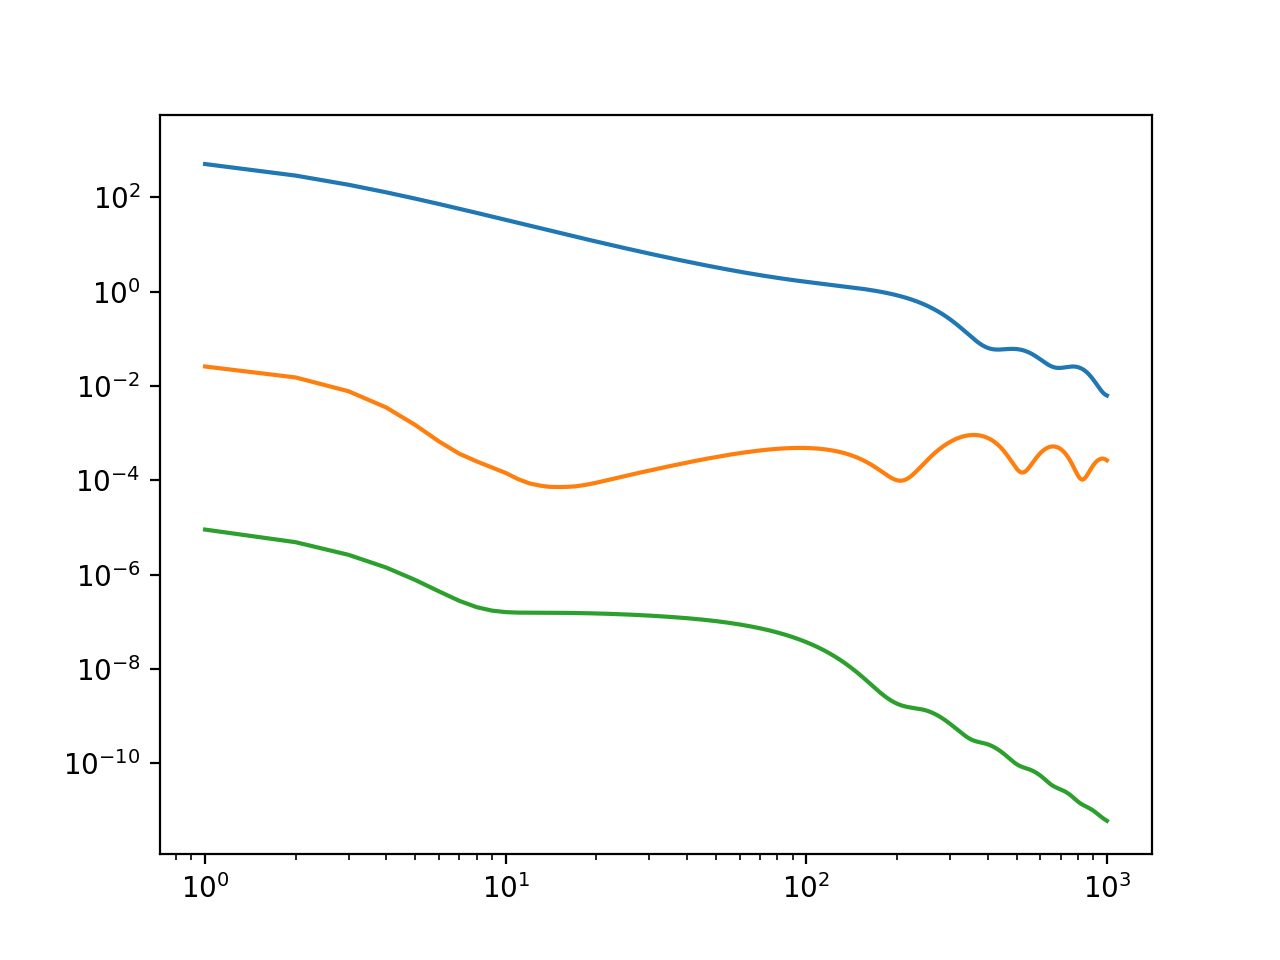

[]

In [36]:
figure()
plot(clr[0])
plot(clr[1])
plot(clr[2])
loglog()

In [37]:
def get_alm(cl,lmax,seed=0):
    random.seed(seed)
    almsize=h.Alm.getsize(lmax,lmax)
    ar=random.normal(size=almsize)
    ai=random.normal(size=almsize)
    alm=zeros(almsize,complex)
    for i in range(almsize):
        l,m=h.Alm.getlm(lmax,i)
        if m==0:
            alm[i]=complex(ar[i],0.)*sqrt(cl[l])
        else:
            alm[i]=complex(ar[i],ai[i])*sqrt(0.5*cl[l])
    return alm

In [38]:
almt=get_alm(clr[0],lmax,1) ; alme=get_alm(clr[1],lmax,2) ; almb=get_alm(clr[2],lmax,3)
true_alm=[almt,alme,almb] ; cltrue=h.alm2cl(true_alm)

tqu=h.alm2map(true_alm,nside,pol=True) ; alm=h.map2alm(tqu,lmax=lmax,iter=0)
cl=h.alm2cl(alm) ; teb=h.alm2map(alm,nside,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [39]:
true_teb=h.alm2map(true_alm,nside,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [40]:
theta_cutoff=3*beta0
print theta_cutoff/pi, theta_cutoff*180./pi

apow=rk.fn_apodization(theta,theta_cutoff=theta_cutoff,apow_frac=0.8)
rad_ker=rk.calc_qu2eb_rad_ker(lmax,theta,pl2)# Default
rad_ker_i,rad_ker_d=rk.calc_qu2queb_rad_ker(lmax,theta,pl2)# Default

# rad_ker=rk.mod_rad_ker(theta,shift=0.0,amp=1,width=0.004,slope=1.,expslope=.5)# Modified
# theta_cutoff=12.5*pi/180.

0.125 22.5


<IPython.core.display.Javascript object>


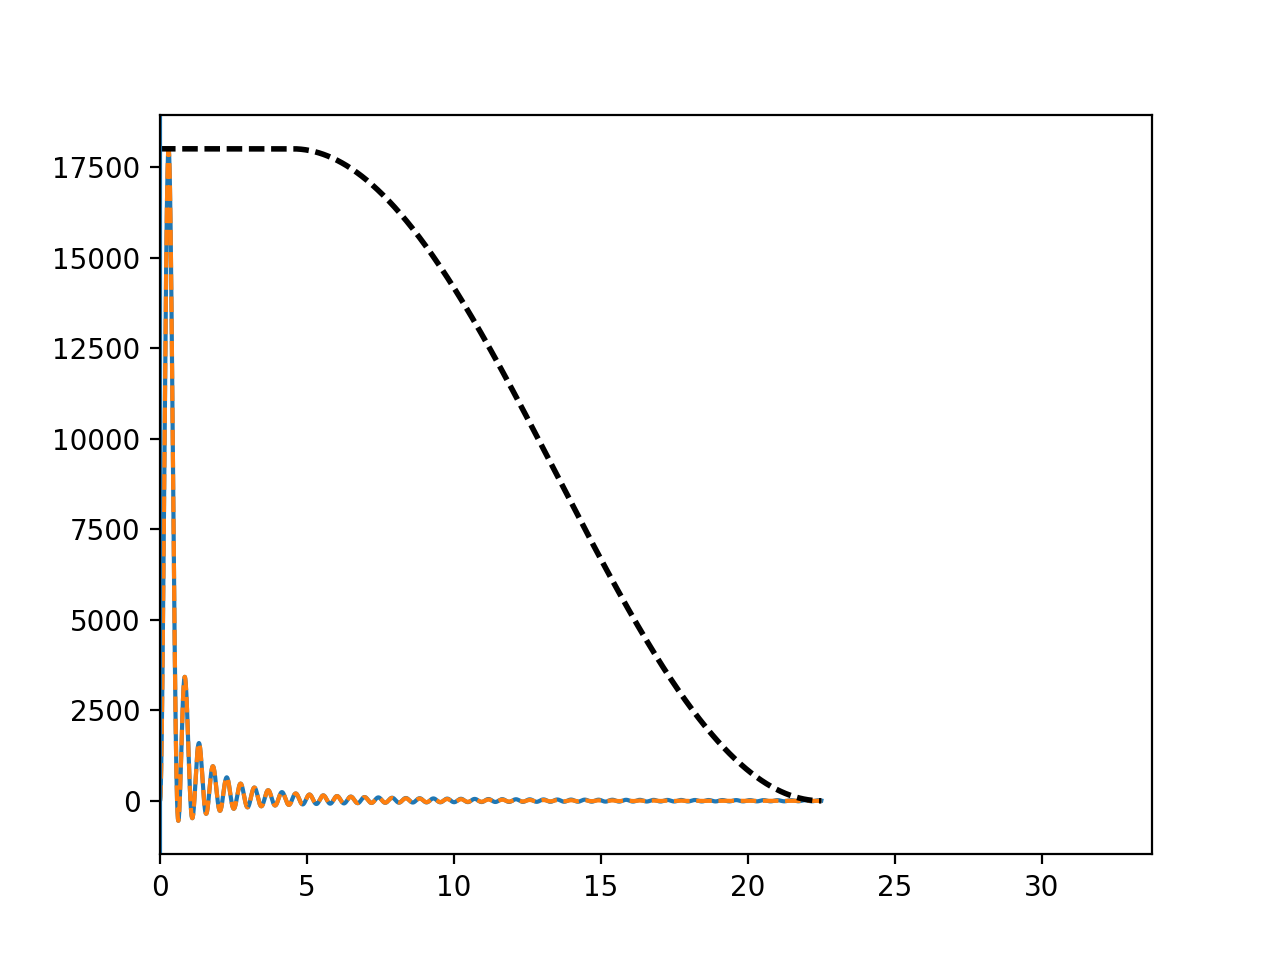

In [41]:
figure()
plot(theta*180./pi,rad_ker)
plot(theta*180./pi,rad_ker*apow,"--")
#plot(theta,rad_ker_i,"--")
plot(theta*180./pi,apow*max(rad_ker),"k--",lw=2)
axvline(pxsize)
xlim(0,min(180,1.5*theta_cutoff*180./pi))
rad_ker=rad_ker*apow

<IPython.core.display.Javascript object>


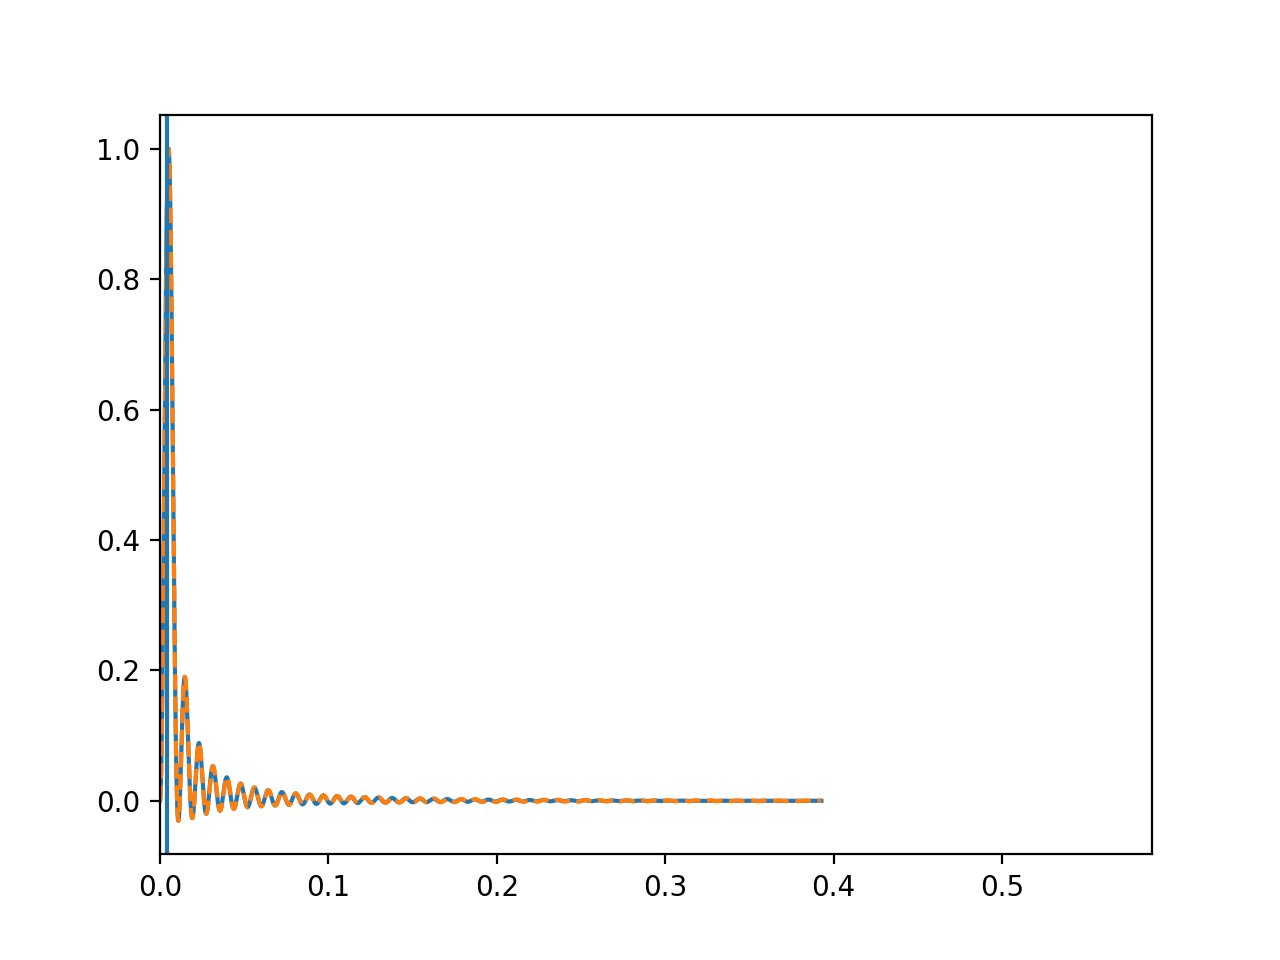

(0, 0.5890486225480862)

In [42]:
ell=arange(lmax+1)
gl=rk.get_gl_from_gbeta(theta,rad_ker,pl2,theta_cutoff,lmax) ;# gl[0:2]=1
rec_rad_ker=rk.get_gbeta_from_gl(theta,gl,pl2)

figure()
plot(theta,rad_ker/max(rad_ker))
plot(theta,rec_rad_ker/max(rec_rad_ker),"--")
axvline(pxsize)
xlim(0,1.5*theta_cutoff)

In [44]:
# f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)
# ax1.plot(theta*180./pi,rad_ker,"r-",lw=2,label="",alpha=0.8)
# #ax1.plot(theta*180./pi,rec_rad_ker,"g--",lw=2,label="Reconstructed",alpha=0.8)
# ax1.plot(theta*180./pi,apow*max(rad_ker),"k--",label="Apodization")
# ax1.grid()
# ax1.legend(loc=0)
# ax1.set_xlim(0,1.*theta_cutoff*180./pi)
# ax1.set_xlabel(r"$\beta$ degrees")
# ax1.set_ylabel(r"$G(\beta)$")

# ax2.plot(ell,gl,"b-",lw=2,label=r"$g_{\ell}$",alpha=0.8)
# ax2.grid()
# ax2.legend(loc=0)
# ax2.set_xlabel(r"multipole $\ell$")
# ax2.set_ylabel(r"$g_{\ell}^2$")
# ylim(0.999,1.001)
# #loglog()
# f.subplots_adjust(hspace=0.3)
# savefig(figpath + "default_rad_ker_spectral_response_rcutoff_4deg.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


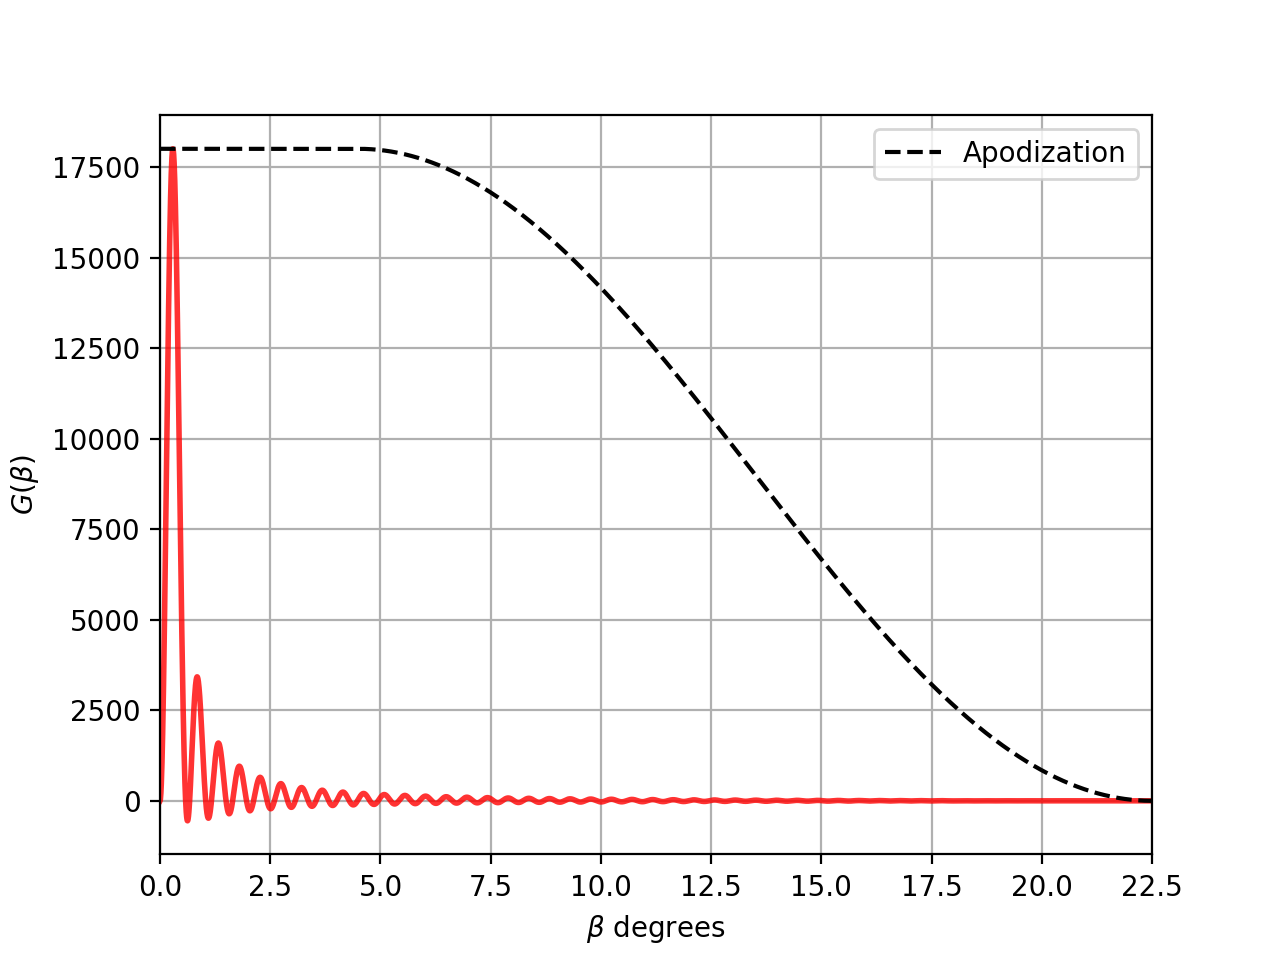

<IPython.core.display.Javascript object>


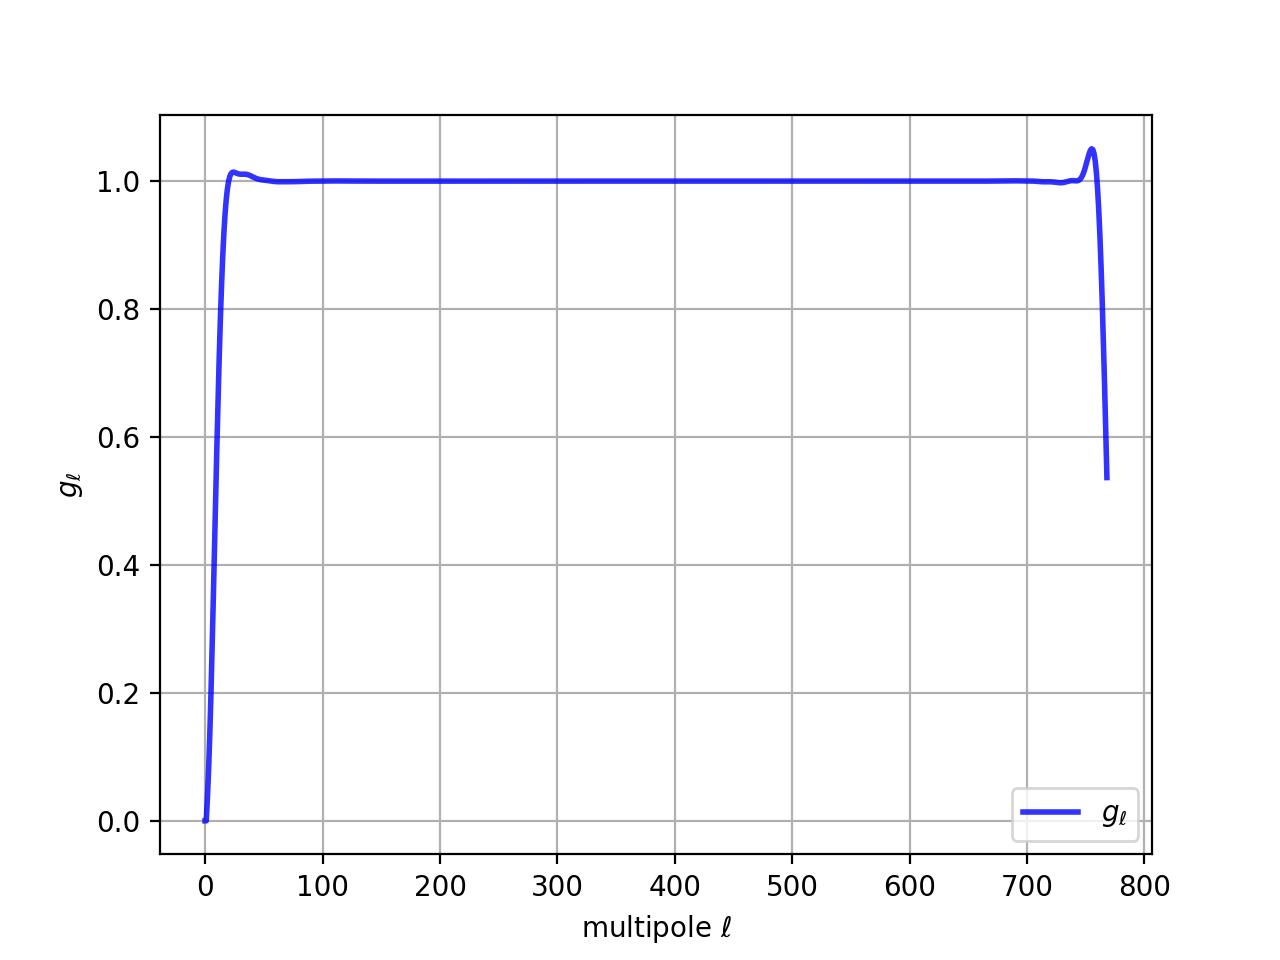

In [70]:
figure()
plot(theta*180./pi,rad_ker,"r-",lw=2,label="",alpha=0.8)
plot(theta*180./pi,apow*max(rad_ker),"k--",label="Apodization")
grid()
legend(loc=0)
xlim(0,1.*theta_cutoff*180./pi)
xlabel(r"$\beta$ degrees")
ylabel(r"$G(\beta)$")
savefig(figpath + "modified_radial_kernel.pdf",dpi=300,bbox_inches="tight")

figure()
plot(ell,gl,"b-",lw=2,label=r"$g_{\ell}$",alpha=0.8)
grid()
legend(loc=0)
xlabel(r"multipole $\ell$")
ylabel(r"$g_{\ell}$")
#ylim(0.999,1.001)
#loglog()
savefig(figpath + "effective_beam.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


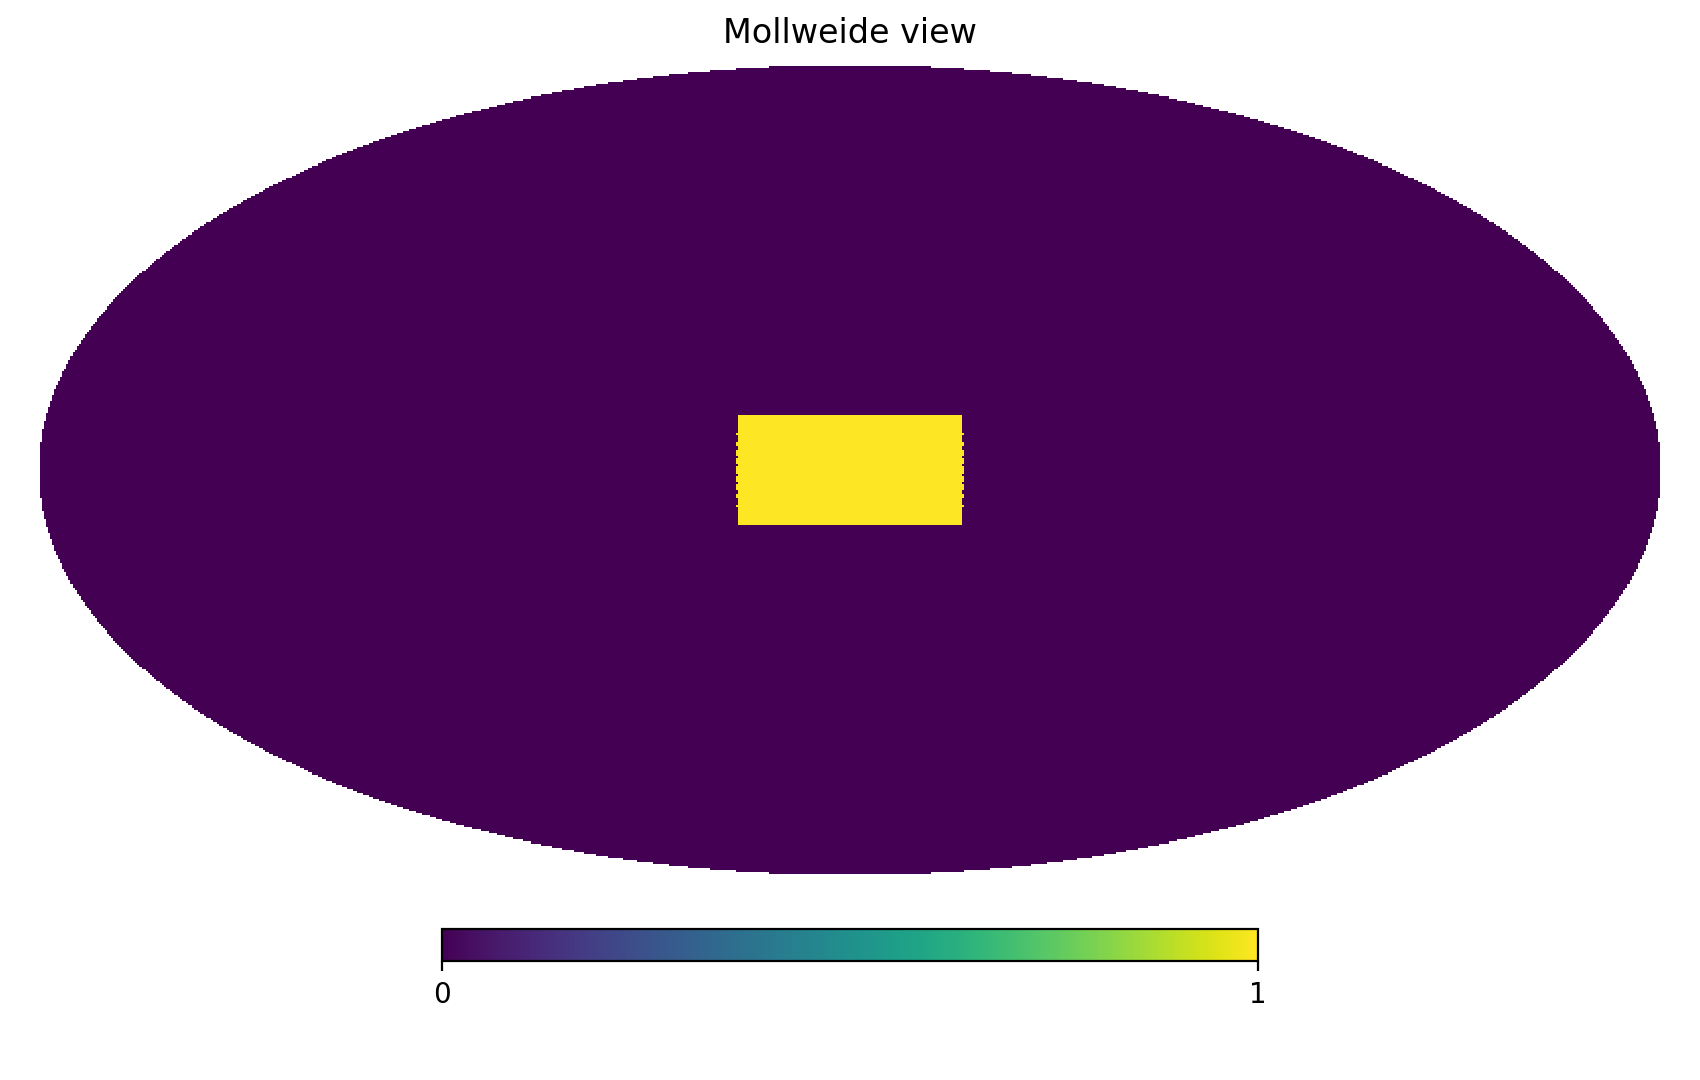

In [47]:
lat=90
tmask=zeros(npix,float)
pmask=zeros(npix,float)
pindex=arange(npix)
theta0,phi0=h.pix2ang(nside,pindex)
theta0=theta0*180/pi ; phi0=phi0*180/pi
wband=10 ; phiband=25
tmask[theta0<lat-wband]=1 ; tmask[theta0>lat+wband]=1.
pmask[phi0<phiband]=1. ; pmask[phi0>360-phiband]=1.
mask=pmask*(1-tmask) ; fsky=sum(mask)/size(mask)
#mask[:]=1.
h.mollview(mask)

ctqu=ac.correct_aliasing_convolve(tqu[1],tqu[2],theta_cutoff,theta,rad_ker_i,iter=3,mask=mask)

h.mollview(ctqu[2])
h.mollview(tqu[2])
#h.gnomview(ctqu[1],xsize=600,reso=5)#,min=-0.5,max=0.5)
#h.gnomview(tqu[1],xsize=600,reso=5)#,min=-0.5,max=0.5)

In [48]:
t1=time.time()
rteb=qb.convert_qu2eb_integrate_masked(tqu[1],tqu[2],theta_cutoff,theta,rad_ker,mask=mask)
print time.time()-t1

136.968994856


<IPython.core.display.Javascript object>


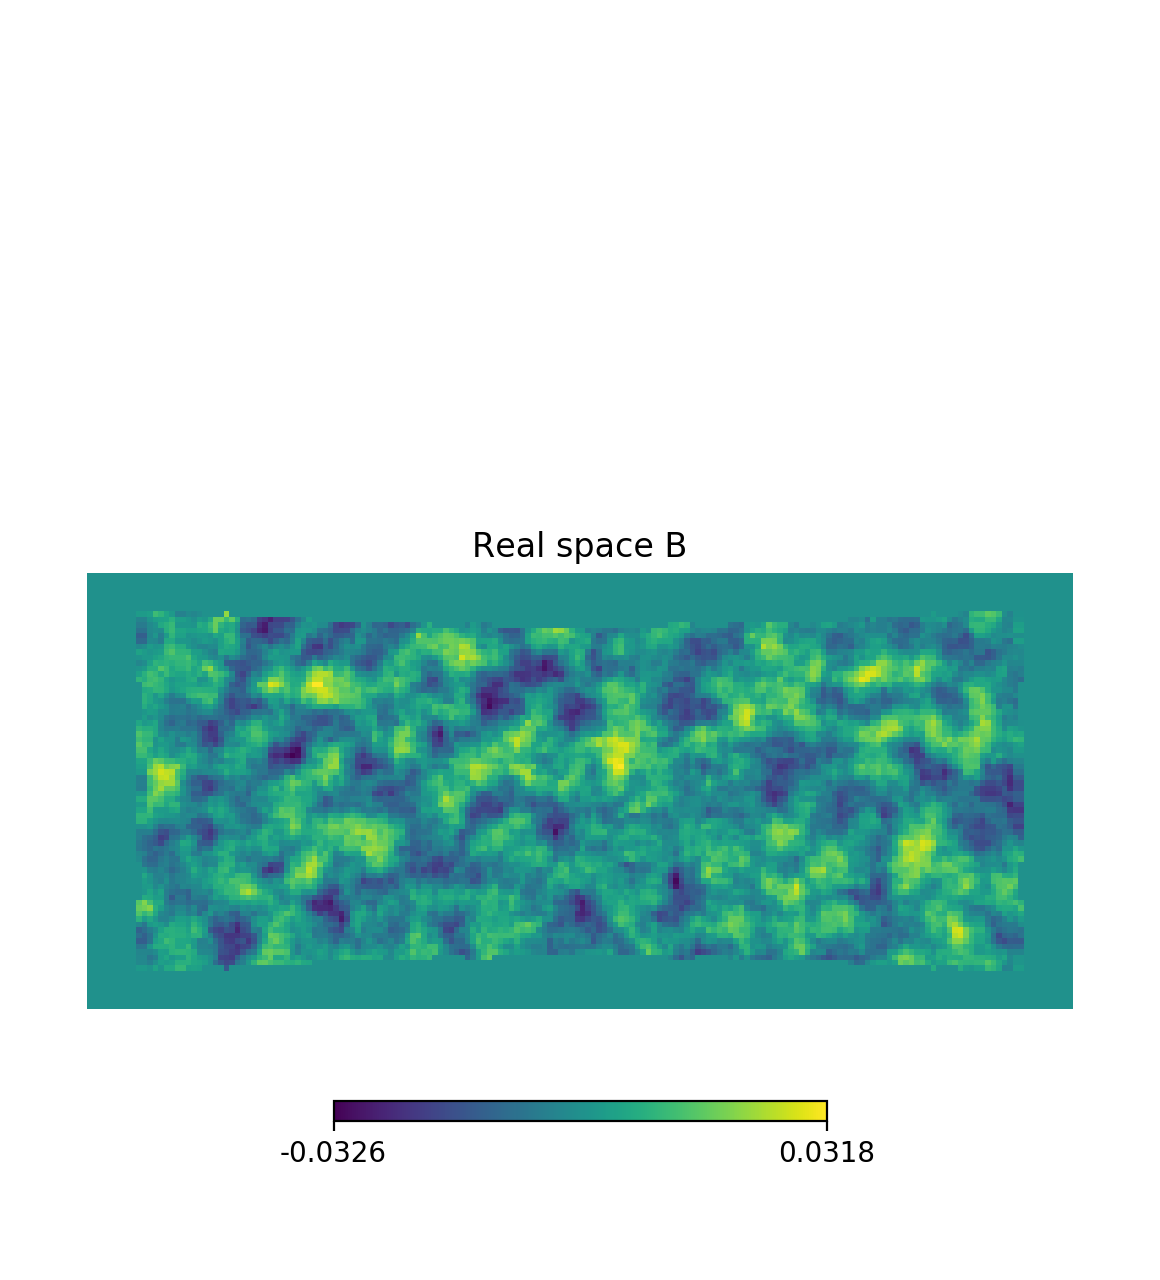

<IPython.core.display.Javascript object>


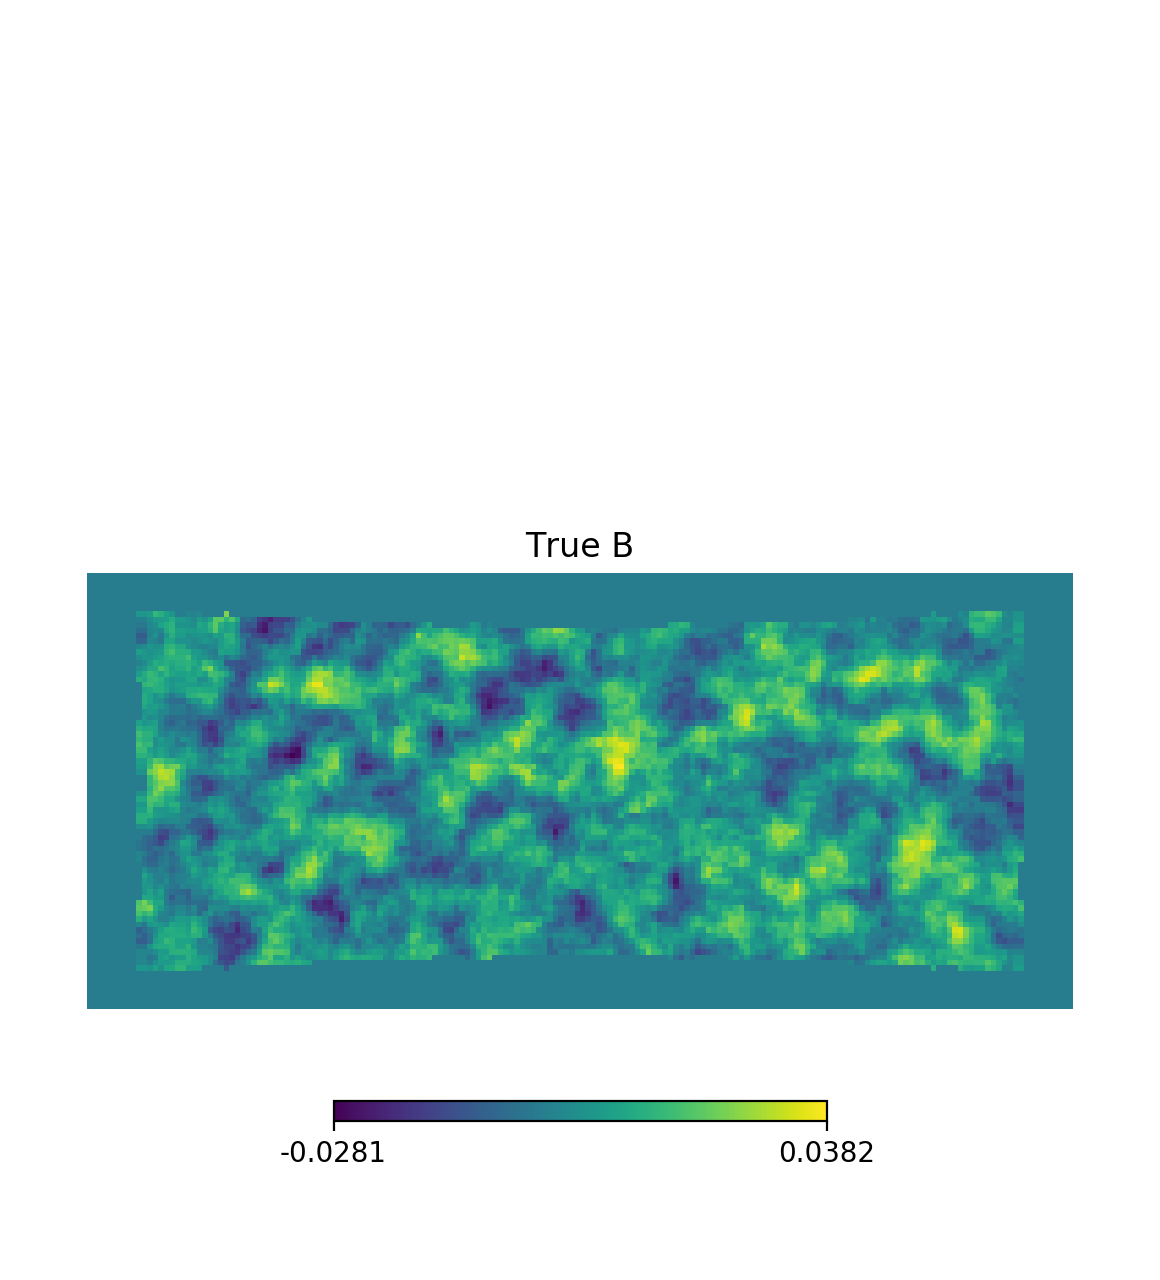

<IPython.core.display.Javascript object>


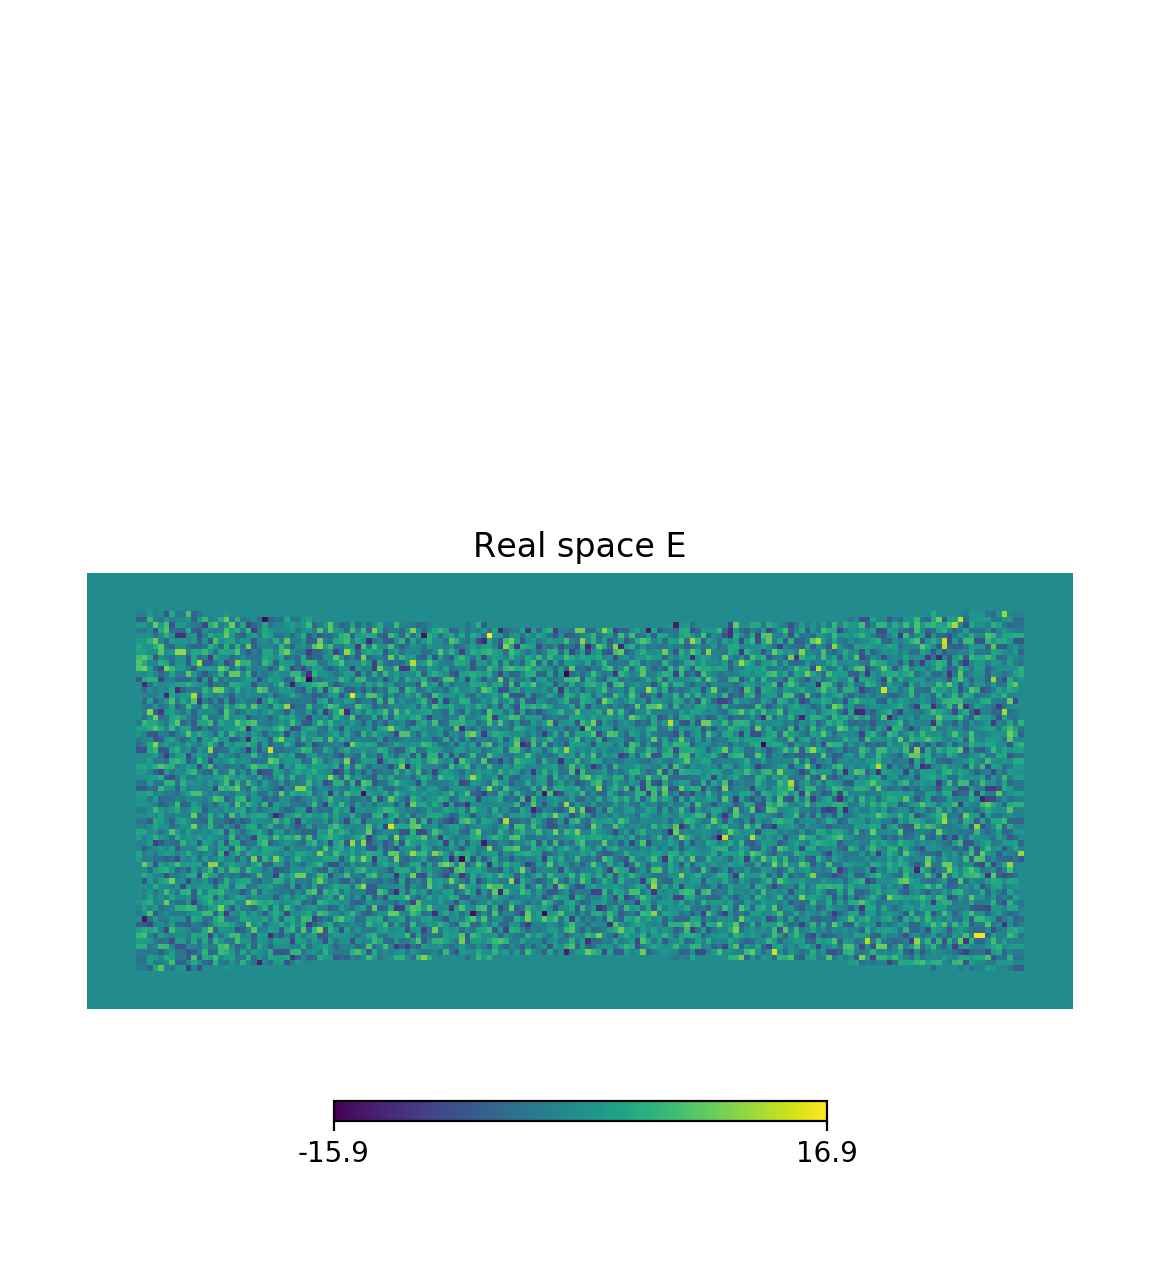

<IPython.core.display.Javascript object>


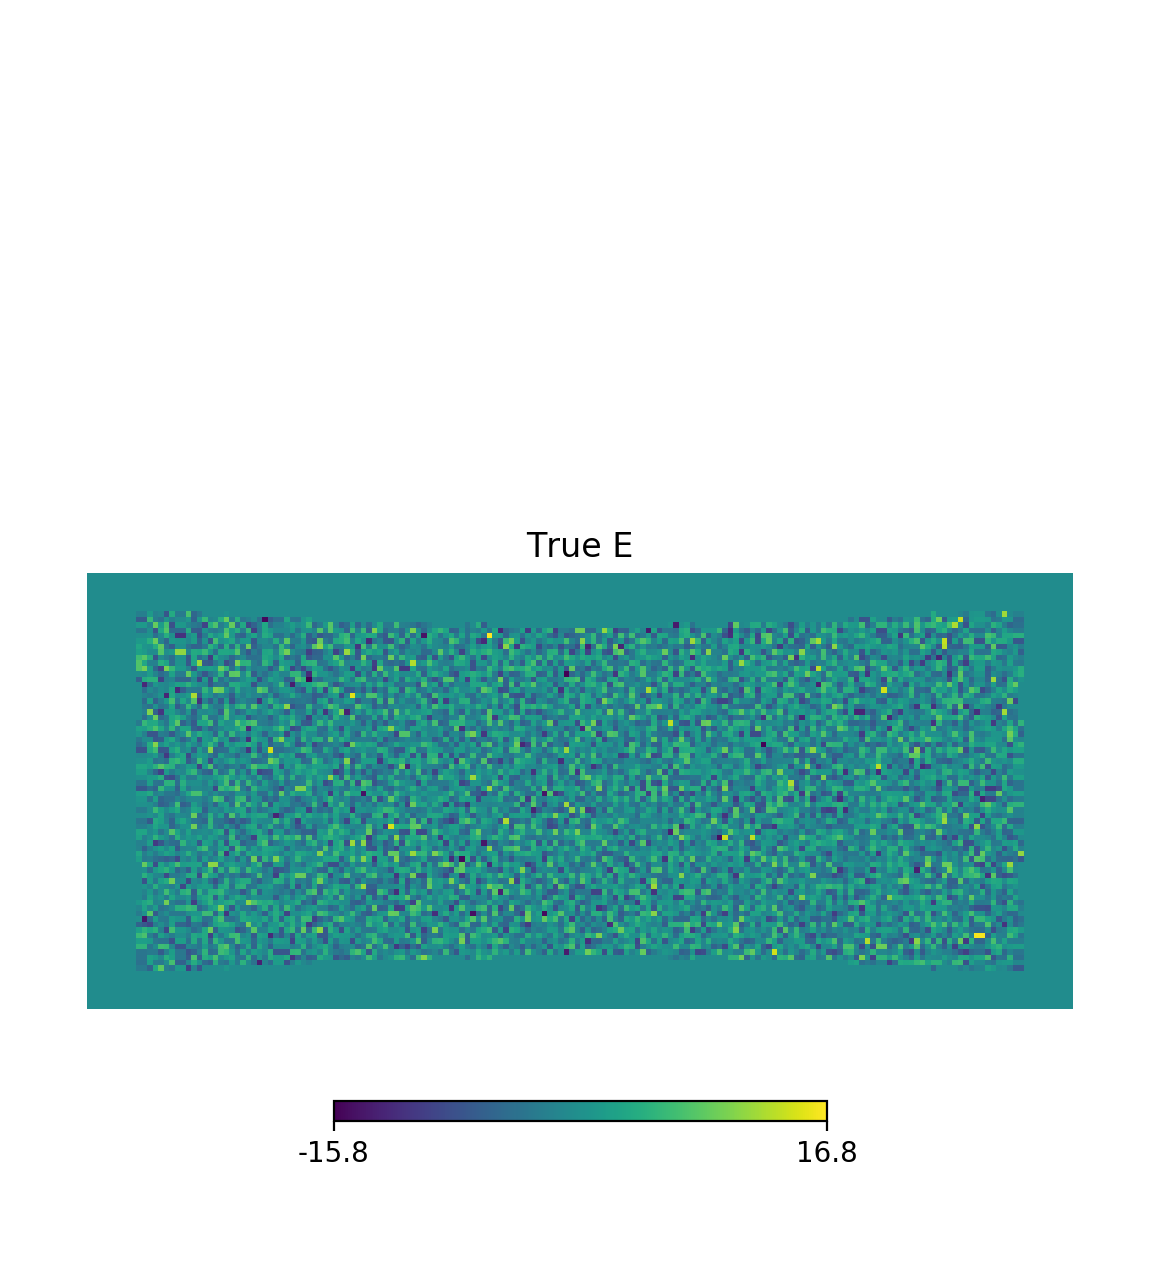

In [63]:
xsize=180 ; ysize=80 ; reso=20
h.gnomview(rteb[2],xsize=xsize,ysize=ysize,reso=reso,rot=(0,90-lat),title="Real space B",notext=True)
savefig(figpath + "real_space_B.pdf")
h.gnomview(true_teb[2]*mask,xsize=xsize,ysize=ysize,reso=reso,rot=(0,90-lat),title="True B",notext=True)
savefig(figpath + "true_B.pdf")

h.gnomview(rteb[1],xsize=xsize,ysize=ysize,reso=reso,rot=(0,90-lat),title="Real space E",notext=True)
savefig(figpath + "real_space_E.pdf")
h.gnomview(teb[1]*mask,xsize=xsize,ysize=ysize,reso=reso,rot=(0,90-lat),title="True E",notext=True)
savefig(figpath + "true_E.pdf")


# h.mollview(rteb[2]*mask)
# h.mollview(teb[2]*mask)


# h.mollview(rteb[1]*mask)
# h.mollview(teb[1]*mask)

In [64]:
clrteb=h.alm2cl(h.map2alm(rteb*mask,lmax=lmax,pol=False,iter=3))
#clhteb=h.alm2cl(h.map2alm(teb*mask,lmax=lmax,pol=False,iter=3))
cltteb=h.alm2cl(h.map2alm(true_teb*mask,lmax=lmax,pol=False,iter=3))

<IPython.core.display.Javascript object>


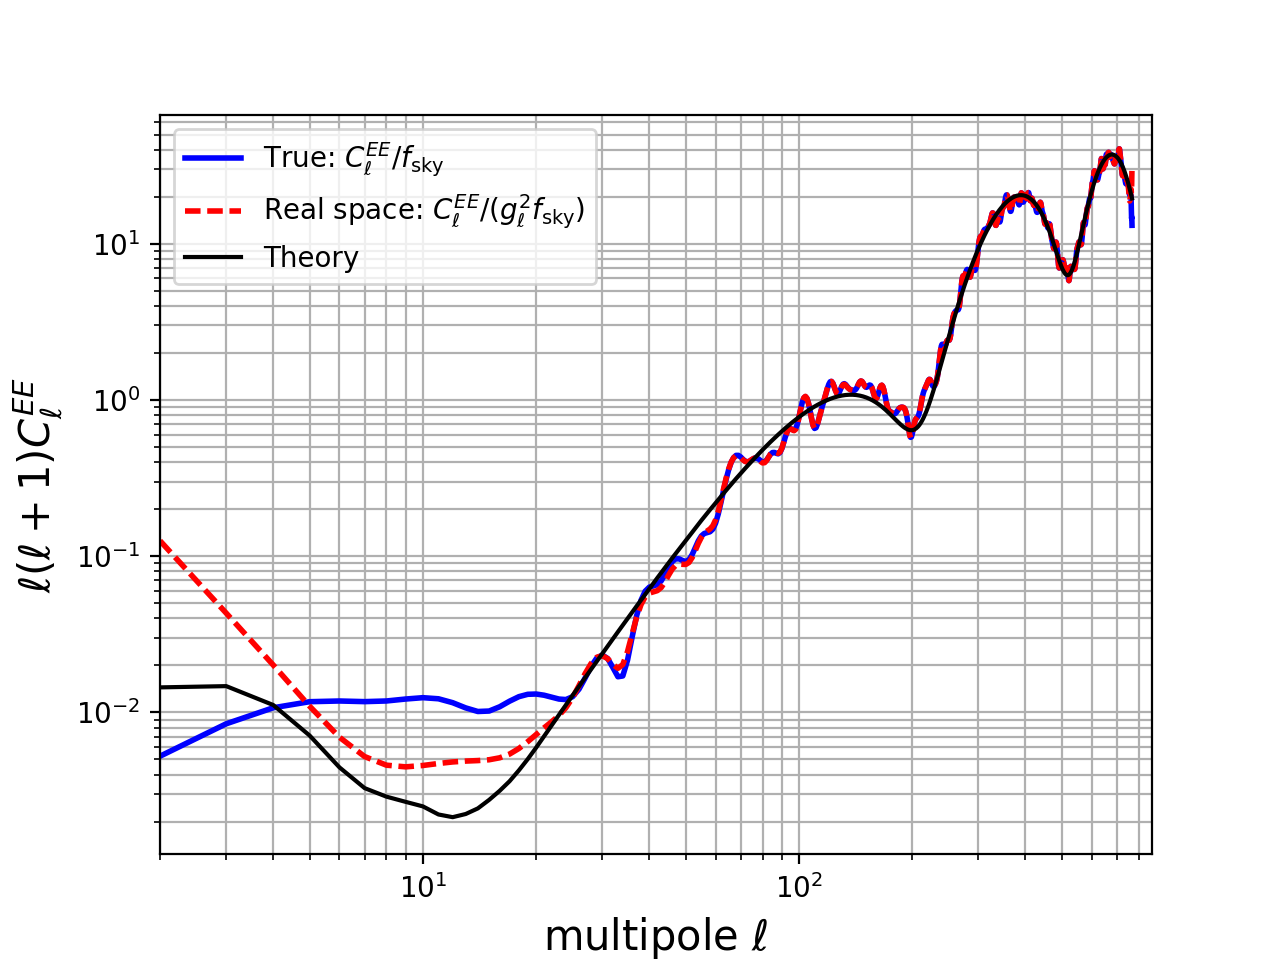

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


<IPython.core.display.Javascript object>


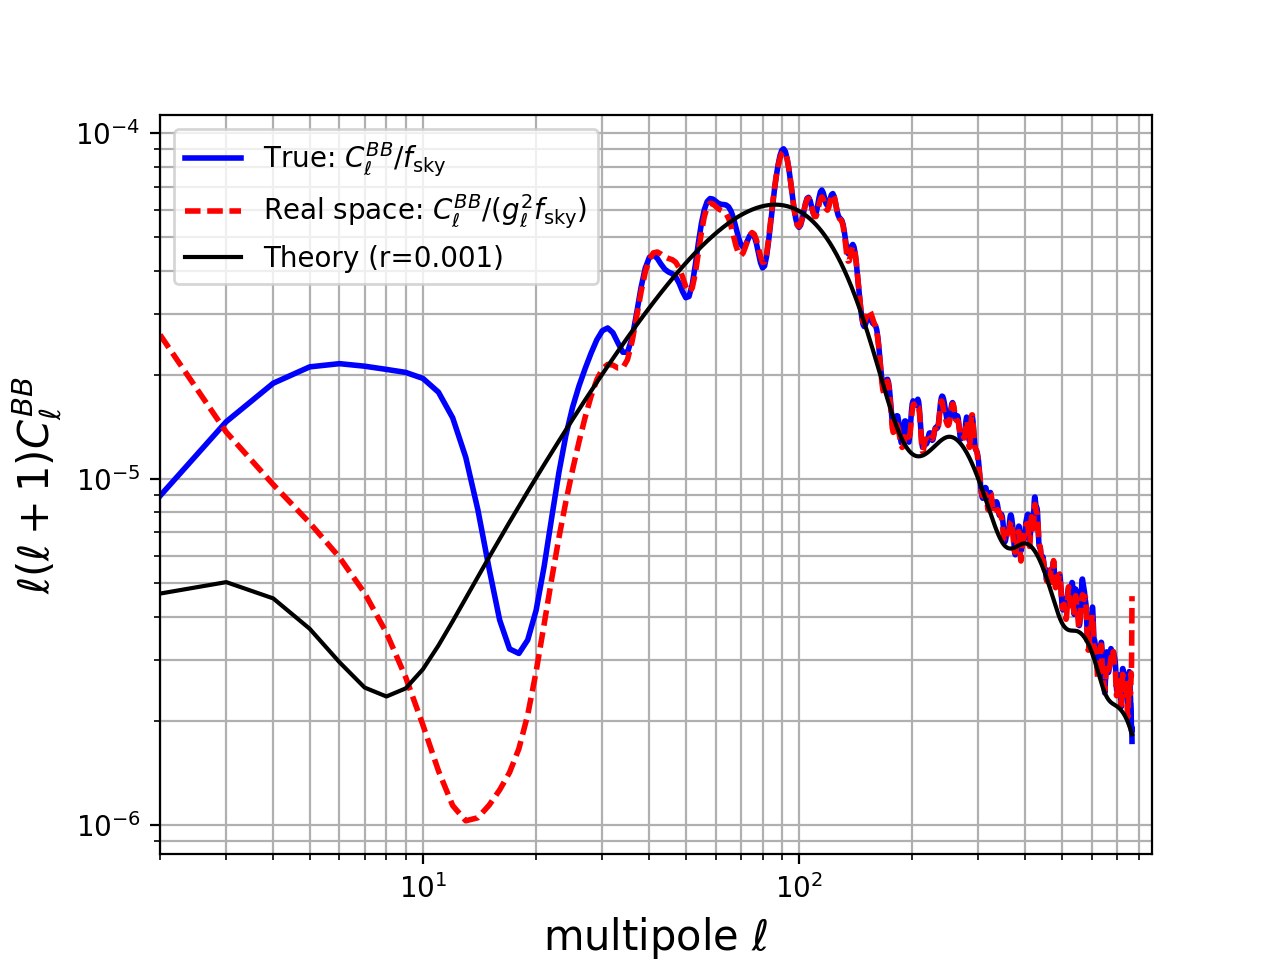

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in divide
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


In [72]:
ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

figure()
plot(ell,fll*cltteb[1]/fsky,"b-",lw=2,label=r"True: $C_{\ell}^{EE}/f_{\rm sky}$")
#plot(ell,fll*clhteb[1]/fsky,"k-",lw=2,label="True")
plot(ell,fll*clrteb[1]/(gl*gl*fsky),"r--",lw=2,label=r"Real space: $C_{\ell}^{EE}/(g_{\ell}^2 f_{\rm sky})$")
plot(ell,fll*clr[1][:lmax+1],"k-",label="Theory")
ylabel("$\ell(\ell+1)C_{\ell}^{EE}$",fontsize=15)
xlabel("multipole $\ell$",fontsize=15)
xlim(2,3*nside+100)
#ylim(0,5)
loglog()
grid(which="both")
legend(loc=0)
savefig(figpath + "real_space_ee_spectra.pdf",dpi=300,bbox_inches="tight")


figure()
plot(ell,fll*cltteb[2]/fsky,"b-",lw=2,label=r"True: $C_{\ell}^{BB}/f_{\rm sky}$")
#plot(ell,fll*clhteb[2]/fsky,"k-",lw=2,label="True (r=0.001)")
plot(ell,fll*clrteb[2]/(gl*gl*fsky),"r--",lw=2,label=r"Real space: $C_{\ell}^{BB}/(g_{\ell}^2 f_{\rm sky})$")
plot(ell,fll*clr[2][:lmax+1],"k-",label="Theory (r=0.001)")
#fill_between(ell,fll*cltemp[2][:lmax+1],fll*cltemp[2][:lmax+1]*100,color="k",alpha=0.3,label="Theory : r=0.001-0.1")
legend(loc=0)
semilogy()
xlim(2,3*nside+100)
#ylim(1e-9,1e-7)
ylabel("$\ell(\ell+1)C_{\ell}^{BB}$",fontsize=15)
xlabel("multipole $\ell$",fontsize=15)
grid(which="both")
loglog()
savefig(figpath + "real_space_bb_spectra.pdf",dpi=300,bbox_inches="tight")